<a href="https://colab.research.google.com/github/keropfia/95-Confidence-and-Prediction-Intervals-ComBase-with-qPCR-data/blob/main/CJ%20ComBase%20final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [142]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd

In [143]:
# pip install uncertainties, if needed
try:
    import uncertainties.unumpy as unp
    import uncertainties as unc
except:
    try:
        from pip import main as pipmain
    except:
        from pip._internal import main as pipmain
    pipmain(['install','uncertainties'])
    import uncertainties.unumpy as unp
    import uncertainties as unc

In [144]:
# import data
datafile_name = 'x and y CJ ComBase.csv'
data = pd.read_csv(datafile_name)
data
x = data['x'].values
y = data['y'].values
n = len(y)

def f(x, a, b):
    return a * x + b

popt, pcov = curve_fit(f, x, y)

Optimal Values
a: 0.039380133941261185
b: -0.4088173942972348
R^2: 0.5787427800957166
Uncertainty
a: 0.0394+/-0.0027
b: -0.41+/-0.04


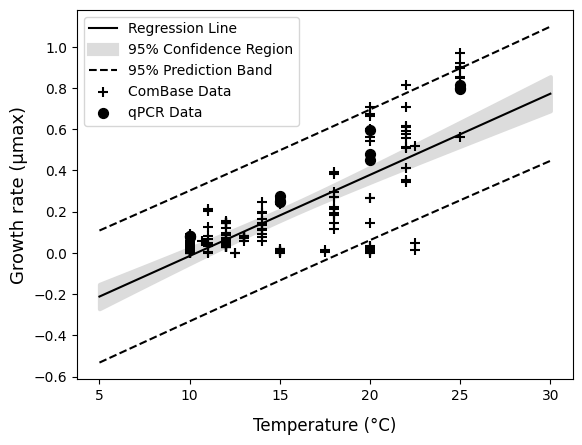

In [145]:
# retrieve parameter values
a = popt[0]
b = popt[1]
print('Optimal Values')
print('a: ' + str(a))
print('b: ' + str(b))

# compute r^2
r2 = 1.0-(sum((y-f(x,a,b))**2)/((n-1.0)*np.var(y,ddof=1)))
print('R^2: ' + str(r2))

# calculate parameter confidence interval
a,b = unc.correlated_values(popt, pcov)
print('Uncertainty')
print('a: ' + str(a))
print('b: ' + str(b))


# calculate regression confidence interval
px = np.linspace(5, 30, 100)
py = a*px+b
nom = unp.nominal_values(py)
std = unp.std_devs(py)

def predband(x, xd, yd, p, func, conf=0.95):
    # x = requested points
    # xd = x data
    # yd = y data
    # p = parameters
    # func = function name
    alpha = 1.0 - conf    # significance
    N = xd.size          # data sample size
    var_n = len(p)  # number of parameters
    # Quantile of Student's t distribution for p=(1-alpha/2)
    q = stats.t.ppf(1.0 - alpha / 2.0, N - var_n)
    # Stdev of an individual measurement
    se = np.sqrt(1. / (N - var_n) * \
                 np.sum((yd - func(xd, *p)) ** 2))
    # Auxiliary definitions
    sx = (x - xd.mean()) ** 2
    sxd = np.sum((xd - xd.mean()) ** 2)
    # Predicted values (best-fit model)
    yp = func(x, *p)
    # Prediction band
    dy = q * se * np.sqrt(1.0+ (1.0/N) + (sx/sxd))
    # Upper & lower prediction bands.
    lpb, upb = yp - dy, yp + dy
    return lpb, upb

lpb, upb = predband(px, x, y, popt, f, conf=0.95)


# plot the regression
plt.plot(px, nom, color='black', label='Regression Line')

# uncertainty lines (95% confidence)
plt.fill_between (px, nom - 1.96 * std, nom + 1.96 * std, color='gainsboro', label='95% Confidence Region',linewidth=3)
plt.legend()
# prediction band (95% confidence)
plt.plot(px, lpb, 'k--',label='95% Prediction Band')
plt.plot(px, upb, 'k--')
plt.ylabel('Growth rate (µmax)')
plt.xlabel('Temperature (°C)')
plt.ylabel('Growth rate (µmax)', fontsize=13)
plt.xlabel('Temperature (°C)', fontsize=12)
plt.xlabel('Temperature (°C)',labelpad=10)
# plot data
plt.scatter(x,y,s=50, label='ComBase Data', marker='+', color='black')
datafile_name = 'x and y CJ qPCR.csv'
data = pd.read_csv(datafile_name)
data
x = data['x'].values
y = data['y'].values
n = len(y)
plt.scatter(x,y,s=50, label='qPCR Data', marker='o', color='black')
plt.legend(loc='best')

# save and show figure
plt.savefig('regression.png')
plt.show()